# SatScan Clustering Classification Model

The purpose of this notebook is to create a classification model to predict whether or not a city belongs to a  high risk cluster.

Cities that belong to a high risk cluster are labeled 1, and cities that do not belong to a high risk cluster are labeled 0.

The features used for this model are the disease rates from the previous year for that city, as well as the state where it is located.

---

Importing libraries

In [1]:
import pandas as pd
import numpy as np

# DataPrep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mixed_naive_bayes import MixedNB
import pickle

# Evaluation
from sklearn import metrics

# Plotting
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoplot
import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

import time
import glob
import shap
root = "../../"

In [19]:
dict_uf_cod = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE',
29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS',
50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

all_models_scores = {}

# DataPrep
*You can skip this and load the csv directly after this section*

---

## DataPrep (models)

Getting a list of all diseases

In [5]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("\\")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

313  diseases


Creating dataframe by using only rows with **at least 80% values that are not NaN** 

In [6]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-1):
    year_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_20" + years[i+1] + ".csv", index_col=0)
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,RISK
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,0


Filling NaN values with zero and getting state code from MUNCOD column

In [7]:
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)
df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


Saving dataframe to csv

In [8]:
df.to_csv("df_classification_satscan.csv")

## DataPrep (2018 predictions)

Getting training data (2008-2017)

In [9]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    year_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_20" + years[i+1] + ".csv", index_col=0)
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N)
    train_df = pd.concat([train_df, year_df])

train_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,RISK
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,0


In [10]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)
train_df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
train_df.to_csv("train_data_classification_satscan.csv")

Getting testing data (2018)

In [12]:
percentage_valid_values = 0.8
test_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_2018.csv", index_col=0)
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df[disease] = disease_df[col_year_disease] 
    disease_df = disease_df.drop(columns={col_year_disease})
    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(test_df.shape[1]*percentage_valid_values)
test_df = test_df.dropna(thresh=N)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,RISK
0,110001,19.656406,23.587687,19.656406,231.945591,NaN,NaN,NaN,11.793844,NaN,...,0.000000,NaN,0.000000,NaN,55.037937,70.763062,3.931281,NaN,19.656406,0
1,110002,8.384182,13.973636,1.863152,32.605152,NaN,0.000000,NaN,1.863152,0.000000,...,0.931576,NaN,29.810424,0.0,13.042061,71.731334,3.726303,0.0,39.126182,0
3,110004,9.038833,20.337374,3.389562,42.934457,NaN,NaN,NaN,0.000000,2.259708,...,0.000000,NaN,NaN,0.0,11.298541,73.440519,1.129854,0.0,5.649271,0
8,110009,3.027551,12.110203,3.027551,6.055101,NaN,NaN,NaN,0.000000,NaN,...,9.082652,NaN,0.000000,NaN,9.082652,45.413261,39.358159,0.0,15.137754,0
9,110010,2.107437,0.000000,2.107437,14.752060,NaN,2.107437,0.0,2.107437,0.000000,...,21.074371,0.0,2.107437,NaN,21.074371,18.966934,0.000000,0.0,219.173463,0


In [13]:
# Fill NaN values with 0
test_df = test_df.fillna(0)

# Get MUNCOD from UF
test_df['UF'] = test_df['MUNCOD'] / 10000
test_df['UF'] = test_df['UF'].astype(int)
test_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(test_df['UF'])
test_df = pd.concat([test_df, dummy], axis=1)
test_df = test_df.drop(['UF'], axis=1)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,110001,19.656406,23.587687,19.656406,231.945591,0.0,0.000000,0.0,11.793844,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,110002,8.384182,13.973636,1.863152,32.605152,0.0,0.000000,0.0,1.863152,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,110004,9.038833,20.337374,3.389562,42.934457,0.0,0.000000,0.0,0.000000,2.259708,...,0,0,0,1,0,0,0,0,0,0
8,110009,3.027551,12.110203,3.027551,6.055101,0.0,0.000000,0.0,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
9,110010,2.107437,0.000000,2.107437,14.752060,0.0,2.107437,0.0,2.107437,0.000000,...,0,0,0,1,0,0,0,0,0,0


In [14]:
test_df.to_csv("test_data_classification_satscan.csv")

# Model
----

Loading dataframe

In [3]:
df = pd.read_csv("df_classification_satscan.csv",index_col=0)
train_df = pd.read_csv("train_data_classification_satscan.csv", index_col=0)
test_df = pd.read_csv("test_data_classification_satscan.csv", index_col=0)

Checking the number of 0s and 1s in TARGET column

In [4]:
unique, counts = np.unique(df["RISK"].values, return_counts=True)
dict(zip(unique, counts))

{0: 6032, 1: 3318}

Defining X and y

In [5]:
X = df.drop(columns=["RISK"])
y = df["RISK"]

X.shape

(9350, 340)

Defining some functions

In [6]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature", how="right")
    final_feat_df = final_feat_df.fillna(0)
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df.sort_values(by="Avg_importance", ascending=False)

In [7]:
def sfm_feature_selector(X_train,y_train):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
    embeded_rf_selector.fit(X_train, y_train)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features (SFM)')
    return embeded_rf_feature

In [8]:
def get_average(scores_list):
    scores_avg_test = []
    for i in range(len(scores_list[0])):
        arr_list = [x[i] for x in scores_list]
        avg_result = np.array(arr_list).mean(axis=0)
        scores_avg_test.append(avg_result)
    return scores_avg_test

In [9]:
def calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None):
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3, zero_division=0))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3, zero_division=0))
    if scores is not None:
        scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                      "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                      "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train, zero_division=0),
                      "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred, zero_division=0)}, ignore_index=True)
        return scores

In [10]:
def get_average_metrics(score):
    print("## Train")
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_score_train = get_average(scores["scores_train"])
    print("accuracy_train:", avg_accuracy_train)
    print("precision_train:", avg_score_train[0].mean())
    print("recall_train:", avg_score_train[1].mean())
    print("f1_score_train:", avg_score_train[2].mean())
    print("## Test")
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_score_test = get_average(scores["scores_test"])
    print("accuracy_test:", avg_accuracy_test)
    print("precision_test:", avg_score_test[0].mean())
    print("recall_test:", avg_score_test[1].mean())
    print("f1_score_test:", avg_score_test[2].mean())

## Naive Bayes

In [72]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    classifier = MixedNB(categorical_features=[X.columns.get_loc(col) for col in list(dict_uf_cod.values())]);
    classifier.fit(X_train,y_train);
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY NAIVE BAYES ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Naive Bayes"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train
[[4826    0]
 [2654    0]]
              precision    recall  f1-score   support

           0      0.645     1.000     0.784      4826
           1      0.000     0.000     0.000      2654

    accuracy                          0.645      7480
   macro avg      0.323     0.500     0.392      7480
weighted avg      0.416     0.645     0.506      7480

Test
[[1206    0]
 [ 664    0]]
              precision    recall  f1-score   support

           0      0.645     1.000     0.784      1206
           1      0.000     0.000     0.000       664

    accuracy                          0.645      1870
   macro avg      0.322     0.500     0.392      1870
weighted avg      0.416     0.645     0.506      1870



=============== RUN 2 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train

In [11]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]
classifier = MixedNB(categorical_features=[X_train.columns.get_loc(col) for col in list(dict_uf_cod.values())]);
classifier.fit(X_train,y_train);

filename = root + 'Dashboard/Models/sav/naive_bayes_satscan.sav'
pickle.dump(classifier, open(filename, 'wb'))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## Logistic Regression

### Using MinMax Scaling

In [35]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1

for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm = MinMaxScaler()
    mm_x = mm.fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)

    print("# Fitting the model")
    classifier = LogisticRegression(random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY LOGISTIC REGRESSION (MINMAX) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Logistic Regression MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4410  416]
 [ 727 1927]]
              precision    recall  f1-score   support

           0      0.858     0.914     0.885      4826
           1      0.822     0.726     0.771      2654

    accuracy                          0.847      7480
   macro avg      0.840     0.820     0.828      7480
weighted avg      0.846     0.847     0.845      7480

Test
[[1081  125]
 [ 217  447]]
              precision    recall  f1-score   support

           0      0.833     0.896     0.863      1206
           1      0.781     0.673     0.723       664

    accuracy                          0.817      1870
   macro avg      0.807     0.785     0.793      1870
weighted avg      0.815     0.817     0.814      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4389  437]
 [ 725 1929]]
      

In [13]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

mm = MinMaxScaler()
mm_x = mm.fit(X_train)
X_train = mm_x.transform(X_train)

classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

filename = root + 'Dashboard/Models/sav/logistic_regression_satscan_mm.sav'
pickle.dump(classifier, open(filename, 'wb'))

### Using Standard Scaling

In [37]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1

for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    sc = StandardScaler()
    sc_x = sc.fit(X_train)
    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)

    print("# Fitting the model")
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY LOGISTIC REGRESSION (STANDARD) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Logistic Regression SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4388  438]
 [ 638 2016]]
              precision    recall  f1-score   support

           0      0.873     0.909     0.891      4826
           1      0.822     0.760     0.789      2654

    accuracy                          0.856      7480
   macro avg      0.847     0.834     0.840      7480
weighted avg      0.855     0.856     0.855      7480

Test
[[1068  138]
 [ 195  469]]
              precision    recall  f1-score   support

           0      0.846     0.886     0.865      1206
           1      0.773     0.706     0.738       664

    accuracy                          0.822      1870
   macro avg      0.809     0.796     0.802      1870
weighted avg      0.820     0.822     0.820      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4372  454]
 [ 666 1988]]
      

In [15]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

sc = StandardScaler()
sc_x = sc.fit(X_train)
X_train = sc_x.transform(X_train)

classifier = LogisticRegression(random_state=42,max_iter=1000)
classifier.fit(X_train, y_train)

filename = root + 'Dashboard/Models/sav/logistic_regression_satscan_sc.sav'
pickle.dump(classifier, open(filename, 'wb'))

### SHAP

# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4399  427]
 [ 728 1926]]
              precision    recall  f1-score   support

           0      0.858     0.912     0.884      4826
           1      0.819     0.726     0.769      2654

    accuracy                          0.846      7480
   macro avg      0.838     0.819     0.827      7480
weighted avg      0.844     0.846     0.843      7480

Test
[[1083  123]
 [ 199  465]]
              precision    recall  f1-score   support

           0      0.845     0.898     0.871      1206
           1      0.791     0.700     0.743       664

    accuracy                          0.828      1870
   macro avg      0.818     0.799     0.807      1870
weighted avg      0.826     0.828     0.825      1870

# Feature importance
                                               Feature  Importance
335                                                 RS    5.438446
97                  OUTRAS_NEOPLASIAS_MALIGN

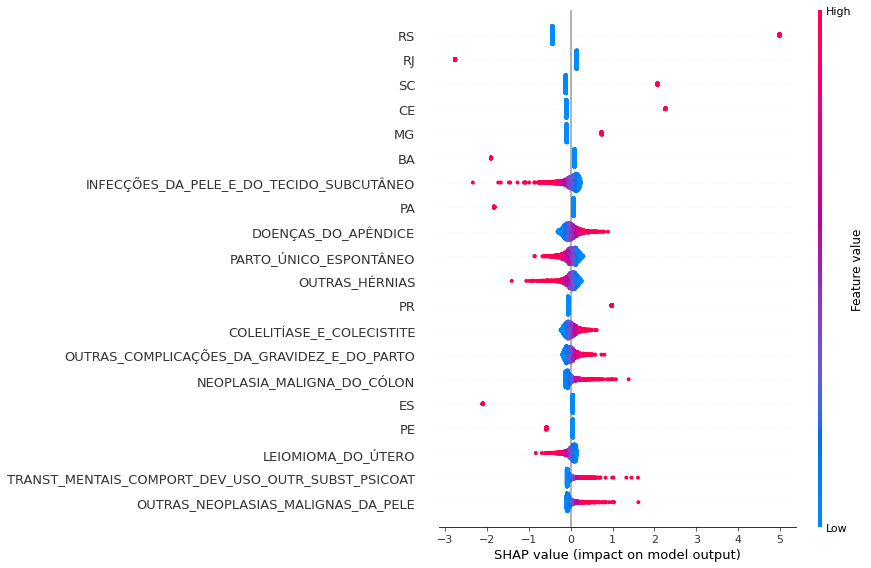

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=1/5, stratify=y)

print("# Scaling features")
mm = MinMaxScaler()
mm_x = mm.fit(X_train)
X_train = pd.DataFrame(mm_x.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(mm_x.transform(X_test), columns=X.columns)
    
print("# Fitting the model")
classifier = LogisticRegression(max_iter=1000,random_state=42)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train)

print("# Feature importance")
importance = classifier.coef_[0]
important_df  = pd.DataFrame({"Feature": X.columns, "Importance": importance}).sort_values(by="Importance",ascending=False)
print(important_df.head(15))

print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

## Random Forest
### No Scaling

In [74]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: SFM")
    selected_sfm_features = sfm_feature_selector(X_train,y_train)
    X_train = X_train[selected_sfm_features]
    X_test = X_test[selected_sfm_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    n_estimators = resultado_gp.x[0]
    max_depth = resultado_gp.x[1]
    min_samples_leaf = resultado_gp.x[2]
    max_features = resultado_gp.x[3]
    
    print("# Fitting the model")
    classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
    classifier.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = classifier.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY RANDOM FOREST ===============")
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Random Forest"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: SFM
113 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4521  305]
 [1391 1263]]
              precision    recall  f1-score   support

           0      0.765     0.937     0.842      4826
           1      0.805     0.476     0.598      2654

    accuracy                          0.773      7480
   macro avg      0.785     0.706     0.720      7480
weighted avg      0.779     0.773     0.756      7480

Test
[[1124   82]
 [ 350  314]]
              precision    recall  f1-score   support

           0      0.763     0.932     0.839      1206
           1      0.793     0.473     0.592       664

    accuracy                          0.769      1870
   macro avg      0.778     0.702     0.716      1870
weighted avg      0.773     0.769     0.751      1870

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: SFM
115 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4379 

The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4172  654]
 [1141 1513]]
              precision    recall  f1-score   support

           0      0.785     0.864     0.823      4826
           1      0.698     0.570     0.628      2654

    accuracy                          0.760      7480
   macro avg      0.742     0.717     0.725      7480
weighted avg      0.754     0.760     0.754      7480

Test
[[1029  177]
 [ 271  393]]
              precision    recall  f1-score   support

           0      0.792     0.853     0.821      1206
           1      0.689     0.592     0.637       664

    accuracy                          0.760      1870
   macro avg      0.741     0.723     0.729      1870
weighted avg      0.755     0.760     0.756      1870

# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: SFM
116 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4301 

The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4299  526]
 [1218 1437]]
              precision    recall  f1-score   support

           0      0.779     0.891     0.831      4825
           1      0.732     0.541     0.622      2655

    accuracy                          0.767      7480
   macro avg      0.756     0.716     0.727      7480
weighted avg      0.762     0.767     0.757      7480

Test
[[1052  155]
 [ 317  346]]
              precision    recall  f1-score   support

           0      0.768     0.872     0.817      1207
           1      0.691     0.522     0.595       663

    accuracy                          0.748      1870
   macro avg      0.730     0.697     0.706      1870
weighted avg      0.741     0.748     0.738      1870

# Get Feature Importance


=============== SUMMARY RANDOM FOREST ===============
# Average Feature Importance
                                              Feature  Avg_importance
0                                     

In [16]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

n_estimators = resultado_gp.x[0]
max_depth = resultado_gp.x[1]
min_samples_leaf = resultado_gp.x[2]
max_features = resultado_gp.x[3]

classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
classifier.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/random_forest_satscan.sav'
pickle.dump(classifier, open(filename, 'wb'))

The objective has been evaluated at this point before.


### SHAP

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.3, stratify=y)

print("# Feature Selection: SFM")
selected_sfm_features = sfm_feature_selector(X_train,y_train)
X_train = X_train[selected_sfm_features]
X_test = X_test[selected_sfm_features]

print("# Bayesian Optimization")
def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

n_estimators = resultado_gp.x[0]
max_depth = resultado_gp.x[1]
min_samples_leaf = resultado_gp.x[2]
max_features = resultado_gp.x[3]

print("# Fitting the model")
classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
classifier.fit(X_train,y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train)

print("# Get Feature Importance")
importance = classifier.feature_importances_
print(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))

# Feature Selection: SFM
117 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[3927  295]
 [1190 1133]]
              precision    recall  f1-score   support

           0      0.767     0.930     0.841      4222
           1      0.793     0.488     0.604      2323

    accuracy                          0.773      6545
   macro avg      0.780     0.709     0.723      6545
weighted avg      0.777     0.773     0.757      6545

Test
[[1676  134]
 [ 533  462]]
              precision    recall  f1-score   support

           0      0.759     0.926     0.834      1810
           1      0.775     0.464     0.581       995

    accuracy                          0.762      2805
   macro avg      0.767     0.695     0.707      2805
weighted avg      0.765     0.762     0.744      2805

# Get Feature Importance
                                               Feature  Importance
115                                              

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


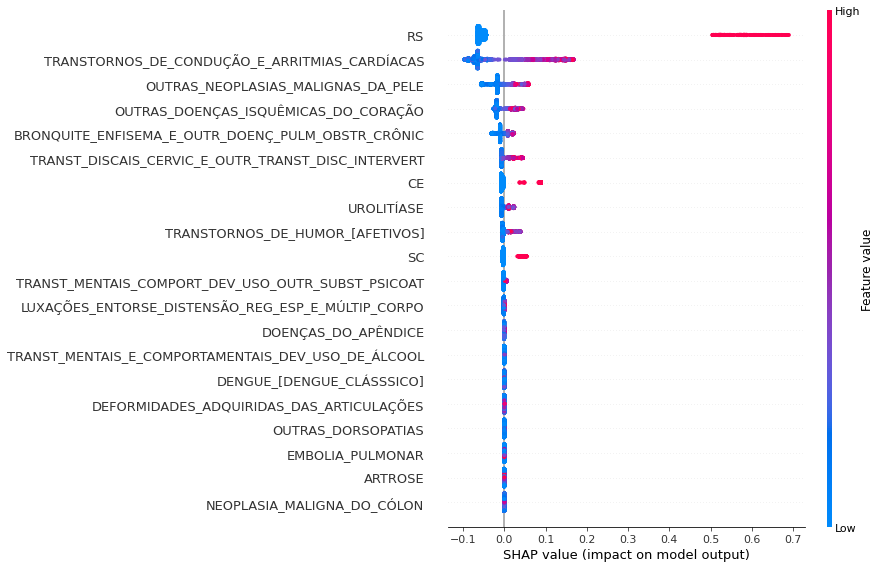

In [117]:
explainer = shap.TreeExplainer(classifier)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)

### SHAP Individual Analysis

In [118]:
print(test_df.loc[test_df['MUNCOD'] == 355030]["RISK"])

data_for_prediction = test_df.loc[test_df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "RISK"])
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(data_for_prediction)

3624    0
Name: RISK, dtype: int64


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [119]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

## SVM
### LinearSVC

#### Using MinMax Scaling

In [20]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm = MinMaxScaler()
    mm_x = mm.fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Fitting the model")
    classifier = LinearSVC(random_state=42, dual=False)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY SVM LINEAR (MINMAX) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM Linear MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4406  420]
 [ 677 1977]]
              precision    recall  f1-score   support

           0      0.867     0.913     0.889      4826
           1      0.825     0.745     0.783      2654

    accuracy                          0.853      7480
   macro avg      0.846     0.829     0.836      7480
weighted avg      0.852     0.853     0.852      7480

Test
[[1073  133]
 [ 199  465]]
              precision    recall  f1-score   support

           0      0.844     0.890     0.866      1206
           1      0.778     0.700     0.737       664

    accuracy                          0.822      1870
   macro avg      0.811     0.795     0.801      1870
weighted avg      0.820     0.822     0.820      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4397  429]
 [ 680 1974]]
      

In [21]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

mm = MinMaxScaler()
mm_x = mm.fit(X_train)
X_train = mm_x.transform(X_train)

classifier = LinearSVC(random_state=42, dual=False)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_linear_satscan_mm.sav'
pickle.dump(classifier, open(filename, 'wb'))

#### Using Standard Scaling

In [22]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    sc = StandardScaler()
    sc_x = sc.fit(X_train)
    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)
    
    print("# Fitting the model")
    classifier = LinearSVC(random_state=42, dual=False)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY SVM LINEAR (STANDARD) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM Linear SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4405  421]
 [ 653 2001]]
              precision    recall  f1-score   support

           0      0.871     0.913     0.891      4826
           1      0.826     0.754     0.788      2654

    accuracy                          0.856      7480
   macro avg      0.849     0.833     0.840      7480
weighted avg      0.855     0.856     0.855      7480

Test
[[1074  132]
 [ 195  469]]
              precision    recall  f1-score   support

           0      0.846     0.891     0.868      1206
           1      0.780     0.706     0.742       664

    accuracy                          0.825      1870
   macro avg      0.813     0.798     0.805      1870
weighted avg      0.823     0.825     0.823      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4393  433]
 [ 677 1977]]
      

In [23]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

sc = StandardScaler()
sc_x = sc.fit(X_train)
X_train = sc_x.transform(X_train)

classifier = LinearSVC(random_state=42, dual=False)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_linear_satscan_sc.sav'
pickle.dump(classifier, open(filename, 'wb'))

### SVC (RBF Kernel)

#### Using MinMax Scaling

In [86]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm = MinMaxScaler()
    mm_x = mm.fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)

    print("\n")
    count += 1
print("=============== SUMMARY SVM RBF (MINMAX) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM RBF MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4515  311]
 [ 723 1931]]
              precision    recall  f1-score   support

           0      0.862     0.936     0.897      4826
           1      0.861     0.728     0.789      2654

    accuracy                          0.862      7480
   macro avg      0.862     0.832     0.843      7480
weighted avg      0.862     0.862     0.859      7480

Test
[[1098  108]
 [ 235  429]]
              precision    recall  f1-score   support

           0      0.824     0.910     0.865      1206
           1      0.799     0.646     0.714       664

    accuracy                          0.817      1870
   macro avg      0.811     0.778     0.790      1870
weighted avg      0.815     0.817     0.811      1870



=============== RUN 2 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating

In [24]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

mm = MinMaxScaler()
mm_x = mm.fit(X_train)
X_train = mm_x.transform(X_train)
X_test = mm_x.transform(X_test)

def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

classifier = SVC(random_state=42,C=C)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_rbf_satscan_mm.sav'
pickle.dump(classifier, open(filename, 'wb'))

#### Using Standard Scaling

In [87]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    sc = StandardScaler()
    sc_x = sc.fit(X_train)
    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)

    print("\n")
    count += 1
print("=============== SUMMARY SVM RBF (STANDARD) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM RBF SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4582  244]
 [ 801 1853]]
              precision    recall  f1-score   support

           0      0.851     0.949     0.898      4826
           1      0.884     0.698     0.780      2654

    accuracy                          0.860      7480
   macro avg      0.867     0.824     0.839      7480
weighted avg      0.863     0.860     0.856      7480

Test
[[1114   92]
 [ 291  373]]
              precision    recall  f1-score   support

           0      0.793     0.924     0.853      1206
           1      0.802     0.562     0.661       664

    accuracy                          0.795      1870
   macro avg      0.798     0.743     0.757      1870
weighted avg      0.796     0.795     0.785      1870



=============== RUN 2 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating

In [25]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]

sc = StandardScaler()
sc_x = sc.fit(X_train)
X_train = sc_x.transform(X_train)

def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

classifier = SVC(random_state=42,C=C)
classifier.fit(X_train, y_train)
    
filename = root + 'Dashboard/Models/sav/svm_rbf_satscan_sc.sav'
pickle.dump(classifier, open(filename, 'wb'))

# All Models
----

Getting a summary of all training results

In [101]:
df_result_train = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_train = get_average(scores["scores_train"])
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_precision_train = avg_score_train[0].mean()
    avg_recall_train = avg_score_train[1].mean()
    avg_f1_score_train = avg_score_train[2].mean()
    df_result_train = df_result_train.append({"Model": model, 
                                  "Accuracy": avg_accuracy_train, "Precision": avg_precision_train,
                                  "Recall": avg_recall_train, "F1-Score": avg_f1_score_train},ignore_index=True)
df_result_train

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.645134,0.322567,0.500000,0.392147
1,Logistic Regression MM,0.844840,0.836988,0.818385,0.826045
2,Logistic Regression SC,0.853957,0.844712,0.832197,0.837695
3,Random Forest,0.768743,0.762049,0.715792,0.726892
4,SVM Linear MM,0.852968,0.845152,0.828854,0.835762
5,SVM Linear SC,0.851444,0.842724,0.828165,0.834427
6,SVM RBF MM,0.860374,0.857686,0.832357,0.842351
7,SVM RBF SC,0.861176,0.867533,0.825521,0.840178


Getting a summary of all testing results

In [100]:
df_result_test = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_test = get_average(scores["scores_test"])
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_precision_test = avg_score_test[0].mean()
    avg_recall_test = avg_score_test[1].mean()
    avg_f1_score_test = avg_score_test[2].mean()
    df_result_test = df_result_test.append({"Model": model, 
                                  "Accuracy": avg_accuracy_test, "Precision": avg_precision_test,
                                  "Recall": avg_recall_test, "F1-Score": avg_f1_score_test},ignore_index=True)
df_result_test

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.645134,0.322567,0.500000,0.392147
1,Logistic Regression MM,0.823957,0.813264,0.795146,0.802397
2,Logistic Regression SC,0.822567,0.809323,0.797794,0.802704
3,Random Forest,0.763102,0.753606,0.711240,0.721396
4,SVM Linear MM,0.824492,0.812595,0.797996,0.803996
5,SVM Linear SC,0.824492,0.813127,0.796914,0.803546
6,SVM RBF MM,0.833904,0.827928,0.801840,0.811636
7,SVM RBF SC,0.820856,0.824555,0.775792,0.790355


# Predictions 2018

Defining X and y

In [9]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]
X_test = test_df.drop(columns=["RISK", "MUNCOD"])
y_test = test_df["RISK"]

mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

print("# Bayesian Optimization")
def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

print("# Fitting the model")
classifier = SVC(random_state=42,C=C,probability=True)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None)

# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[5167  318]
 [ 809 2121]]
              precision    recall  f1-score   support

           0      0.865     0.942     0.902      5485
           1      0.870     0.724     0.790      2930

    accuracy                          0.866      8415
   macro avg      0.867     0.833     0.846      8415
weighted avg      0.866     0.866     0.863      8415

Test
[[520  27]
 [189 199]]
              precision    recall  f1-score   support

           0      0.733     0.951     0.828       547
           1      0.881     0.513     0.648       388

    accuracy                          0.769       935
   macro avg      0.807     0.732     0.738       935
weighted avg      0.794     0.769     0.753       935



In [14]:
# gd = gpd.read_file(root + "Maps/BRMUE250GC_SIR.shp")

# mun_risk_ids_pred = test_df[y_pred == 1]['MUNCOD'].astype(int).tolist()
# mun_risk_ids_true = test_df[y_test == 1]['MUNCOD'].astype(int).tolist()

# mun_risk_ids = [x for x in mun_risk_ids_pred if x in mun_risk_ids_true]
# mun_risk_ids_wrong = [x for x in mun_risk_ids_pred if x not in mun_risk_ids_true]
# mun_risk_ids_missing = [x for x in mun_risk_ids_true if x not in mun_risk_ids_pred]

In [18]:
gd = gpd.read_file(root + "Maps/BRMUE250GC_SIR.shp")

mun_risk_ids_pred = test_df[y_pred == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true = test_df[y_test == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_1_correct = [x for x in mun_risk_ids_pred if x in mun_risk_ids_true]

mun_risk_ids_pred_0 = test_df[y_pred == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true_0 = test_df[y_test == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_0_correct = [x for x in mun_risk_ids_pred_0 if x in mun_risk_ids_true_0]

mun_risk_ids = mun_risk_ids_1_correct + mun_risk_ids_0_correct
mun_risk_ids_wrong = [x for x in mun_risk_ids_pred if x not in mun_risk_ids_true] + [x for x in mun_risk_ids_true if x not in mun_risk_ids_pred]

In [19]:
def remove_last_digit(x):
    return np.floor(x.astype(int) / 10).astype(int)

In [17]:
# fig, ax = plt.subplots(figsize=(15,15))
# gd.plot(ax=ax, color="white", edgecolor='black')
# gd_risk = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids)]
# plot_risk = gd_risk.plot(ax=ax, color="blue")

# gd_risk_wrong = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_wrong)]
# plot_risk_wrong = gd_risk_wrong.plot(ax=ax, color="red")

# gd_risk_missing = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_missing)]
# plot_risk_missing = gd_risk_missing.plot(ax=ax, color="yellow")

# blue_patch = mpatches.Patch(color='blue', label='Right')
# red_patch = mpatches.Patch(color='red', label='Wrong')
# yellow_patch = mpatches.Patch(color='yellow', label='Missing')
# plt.legend(handles=[yellow_patch,red_patch,blue_patch])
# plt.axis('off')

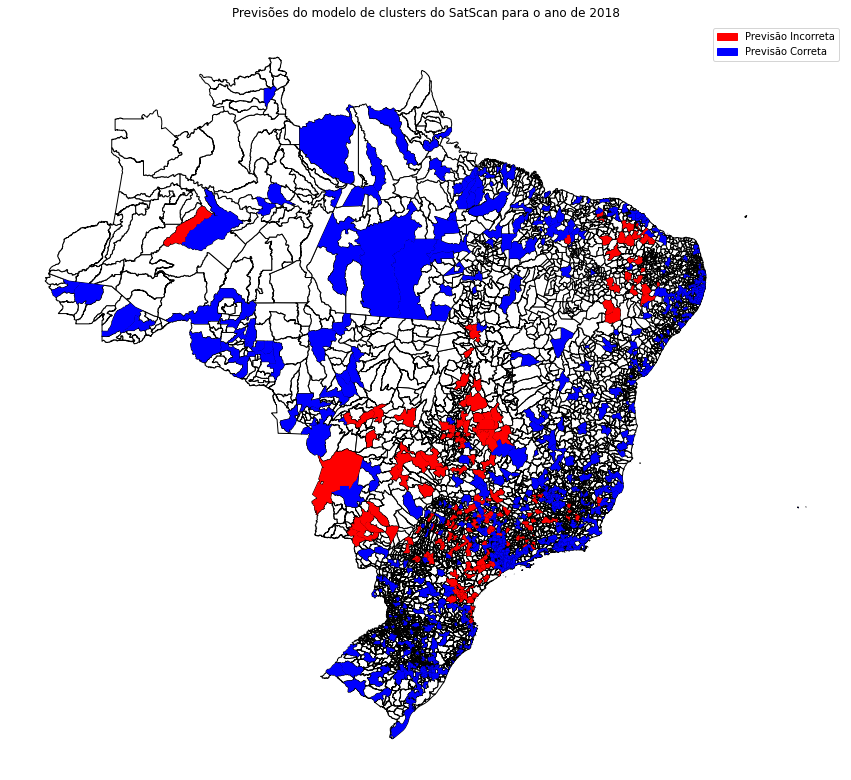

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
gd.plot(ax=ax, color="white", edgecolor='black')
gd_risk = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids)]
plot_risk = gd_risk.plot(ax=ax, color="blue")

gd_risk_wrong = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_wrong)]
plot_risk_wrong = gd_risk_wrong.plot(ax=ax, color="red")

blue_patch = mpatches.Patch(color='blue', label='Previsão Correta')
red_patch = mpatches.Patch(color='red', label='Previsão Incorreta')
plt.title("Previsões do modelo de clusters do SatScan para o ano de 2018")
plt.legend(handles=[red_patch,blue_patch])
plt.axis('off')
plt.savefig("previsoes_clusters_satscan.png")